# End to End Time Series Analysis: Store Demand Forecast

- [Data Source](https://www.kaggle.com/c/demand-forecasting-kernels-only)    

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
data = pd.read_csv('data/item_demand_forecast.csv')
demands = data.set_index(pd.to_datetime(data.date)).drop('date',axis=1)
demands.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


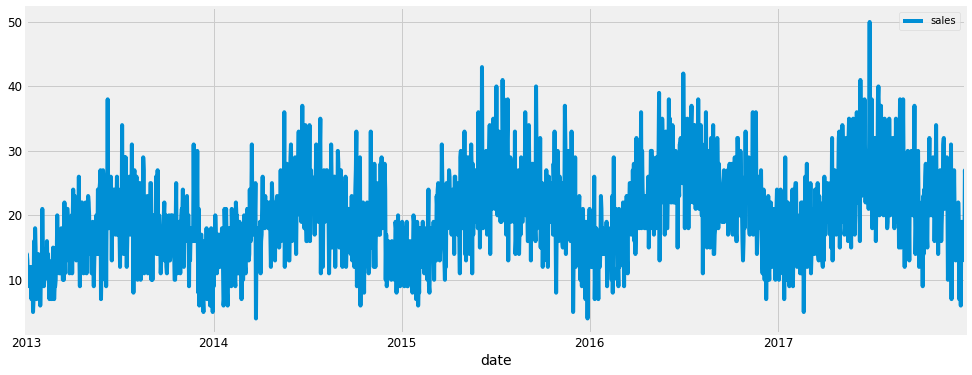

In [3]:
bool_mask = ((demands.item==1) & (demands.store==1))
ys = demands[bool_mask].drop(['item','store'], axis=1).copy()
_= ys.plot(figsize=(15, 6))

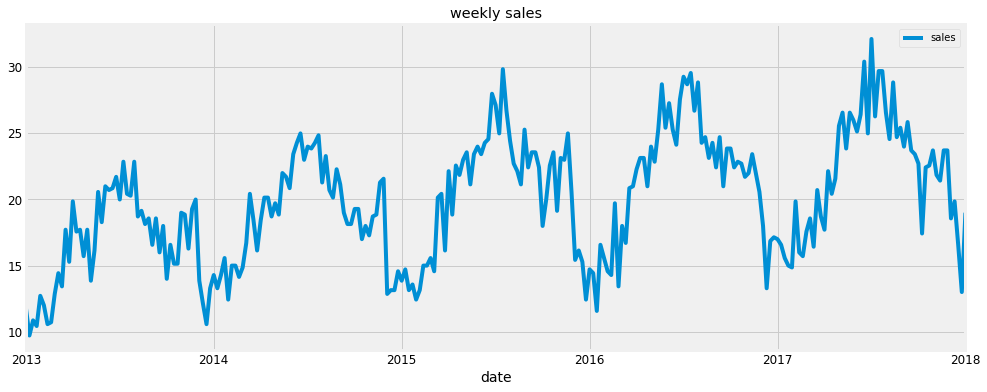

In [4]:
# work with average weekly demand, resample weekly at every Monday
y = ys.resample('W-MON').mean()
_ = y.plot(figsize=(15, 6), title='weekly sales')

In [5]:
y.head()

,sales
date,
2013-01-07,11.857143
2013-01-14,9.714286
2013-01-21,10.857143
2013-01-28,10.428571
2013-02-04,12.714286


## Series Decomposition

We can use a time-series decomposition method to decompose our time series into three distinct components: 
- trend 
- seasonality
- noise

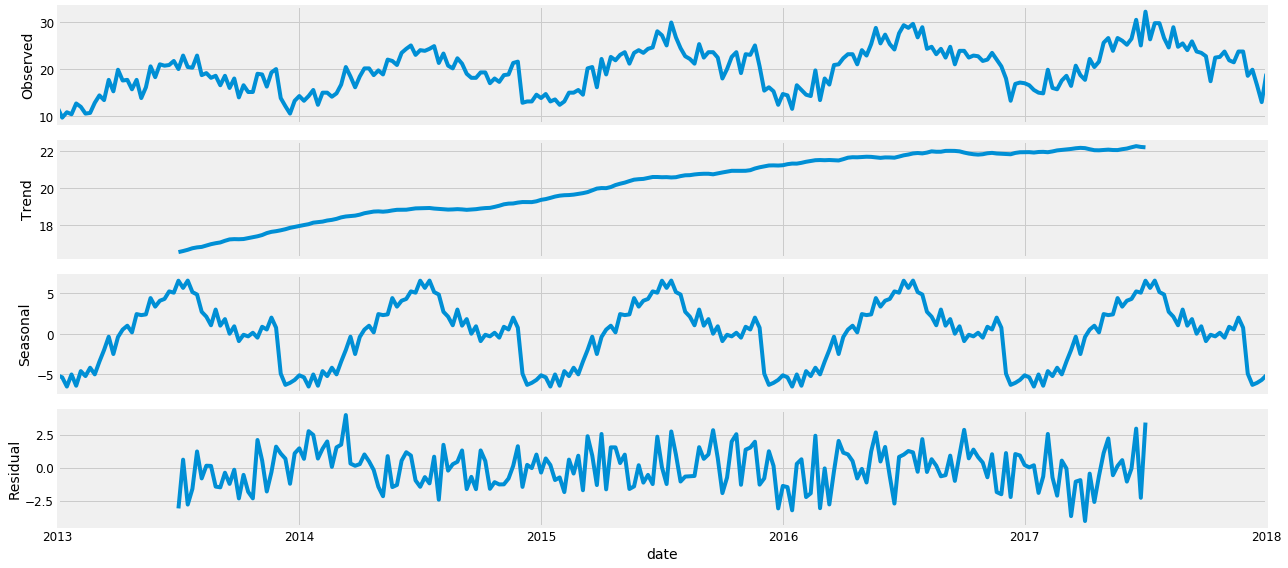

In [6]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()

The plot clearly shows that sales data is not stationary. 
- There is a clear increasing trend, which suggests we will need to perform differencing
- There is seasonality, more or les consistent across years. Will it be a good idea to use data for a single year?
- Noise term seems to have different variance at the beginning of 2015, we may need to perform some sort of transformation

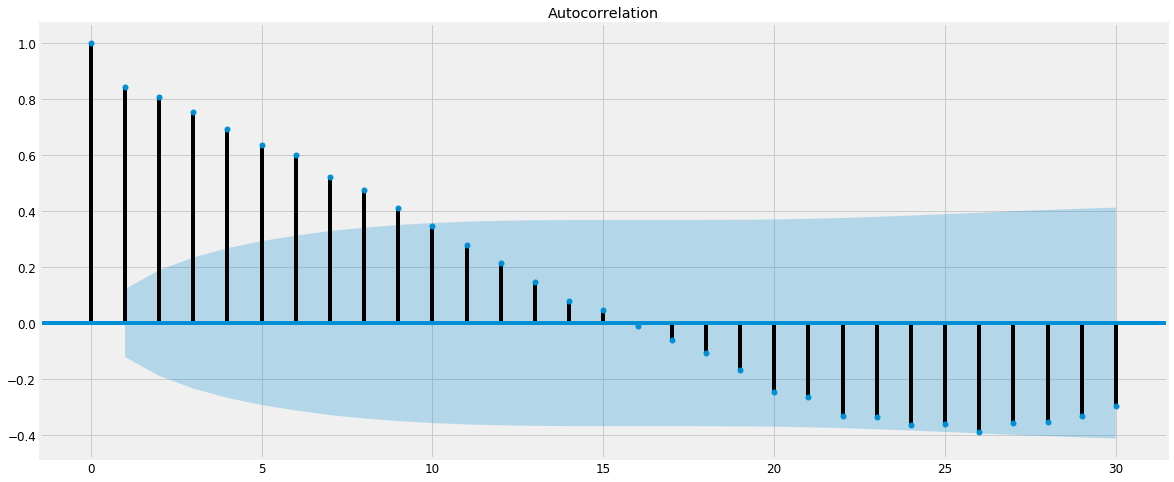

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(y, lags=30)
plt.show()

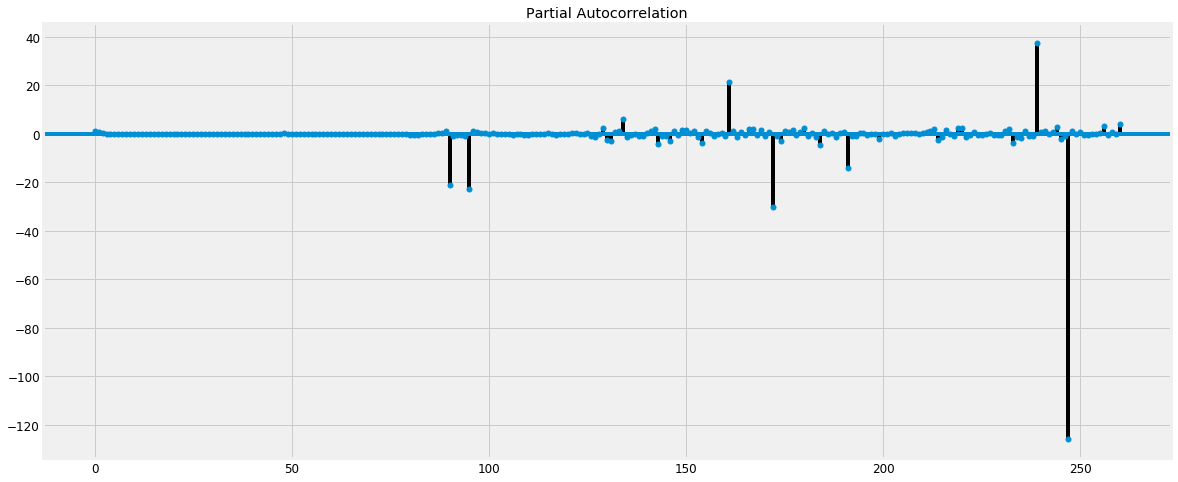

In [8]:
plot_pacf(y)
plt.show()

## Forecasting with ARIMA

We now use a classic time series method for time-series forecasting, known as ARIMA(p, d, q)

- p is order of the Auto Regressive component and captures the effect of previous sales on the current sale (some aspect of seasonality)
- d is the order of differencing required to eliminate trends in the data
- q is the Moving Average component and captures the effect of noise

So the question is how do we determine p, d and q? **Try Grid Search**

In [9]:
p = d = q = range(1, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (1, 1, 2) x (1, 1, 2, 12)
SARIMAX: (1, 1, 2) x (1, 2, 1, 12)
SARIMAX: (1, 2, 1) x (1, 2, 2, 12)
SARIMAX: (1, 2, 1) x (2, 1, 1, 12)


In [10]:
def grid_search():

    warnings.filterwarnings("ignore")
    aic = {}
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                name = param+param_seasonal
                aic[name] = results.aic
                print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    return aic

The above output suggests that SARIMAX(2, 1, 3)x(2, 1, 1, 12) yields the lowest AIC value of 297.78. Therefore we should consider this to be optimal option.

## Fitting the Model

In [11]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(2, 2, 1),
                                seasonal_order=(2, 1, 2, 6),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4660      0.063     -7.361      0.000      -0.590      -0.342
ar.L2         -0.1203      0.068     -1.770      0.077      -0.253       0.013
ma.L1         -1.0000     99.770     -0.010      0.992    -196.546     194.546
ar.S.L6       -0.4814      0.326     -1.478      0.139      -1.120       0.157
ar.S.L12       0.0022      0.004      0.498      0.618      -0.006       0.011
ma.S.L6       -0.4772      0.294     -1.623      0.105      -1.054       0.099
ma.S.L12      -0.6132      0.324     -1.893      0.058      -1.248       0.022
sigma2         4.8706    485.966      0.010      0.992    -947.605     957.346


The above summary shows that
- The estimated coefficient for the AR component (0.0146) is not significant since the p-value is pretty large (0.966)
- The estimated paramter for the MA component is significant
- The estimated stantard deviation of the noise term is significant. 

## Model Diagnostic

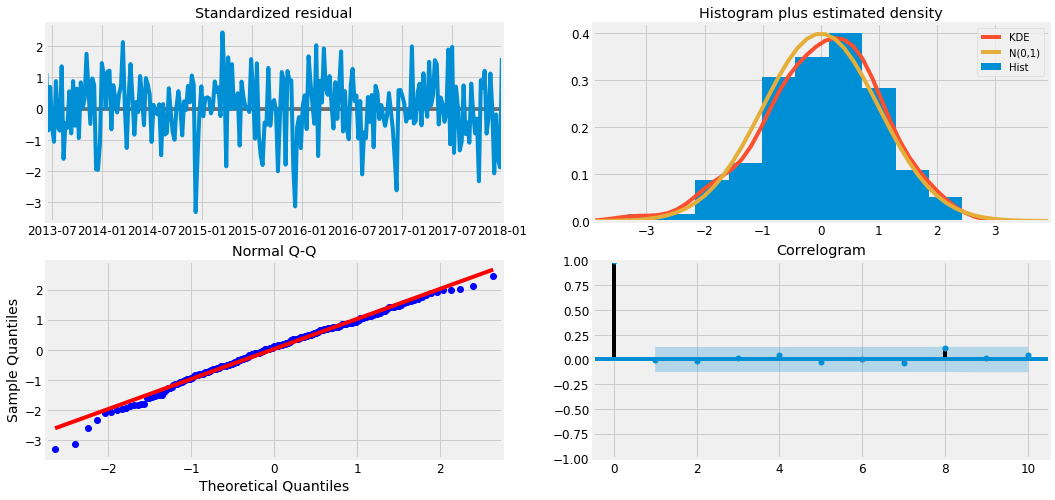

In [12]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

Not perfect but the model diagnostics plot suggests that the model residuals are near normally distributed.

## Validating 

Let do some forecasts starting on 2017–01–01 to the end of the data.

In [13]:
y['2017'].head()

,sales
date,
2017-01-02,17.000000
2017-01-09,16.571429
2017-01-16,15.571429
2017-01-23,15.000000
2017-01-30,14.857143


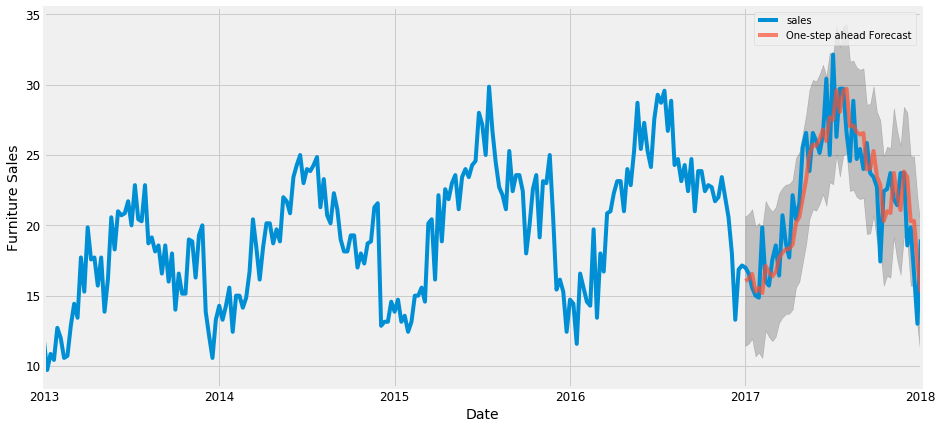

In [14]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-02'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

## Evaluation

In [15]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-02':].values.flatten()
mse = ((y_forecasted - y_truth) ** 2).mean()
print('Mean = {}, MSE = {}, RMSE = {}'.format(round(y_truth.mean(), 2), round(mse, 2), round(mse**(0.5),2)))

Mean = 22.11, MSE = 5.83, RMSE = 2.41


## Forecasting the Feature

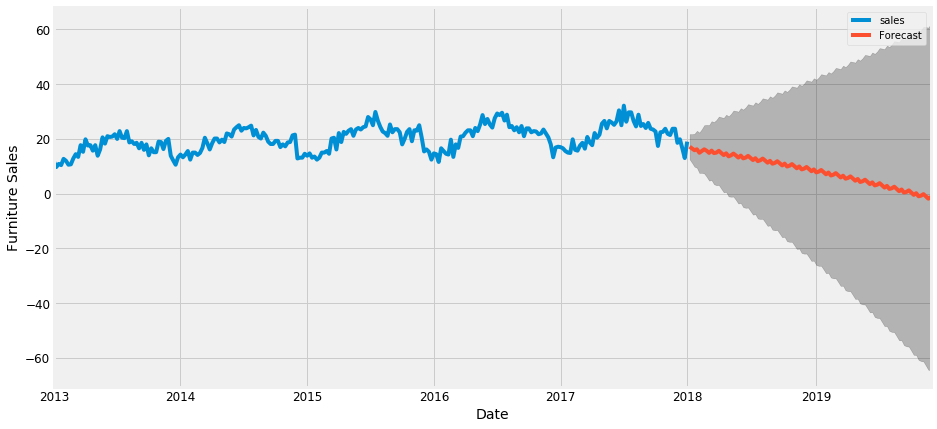

In [16]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

More improvement coming...